<a href="https://colab.research.google.com/github/mahikshith/Langgraph/blob/main/Advanced_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install langgraph langchain

In [ ]:
!pip install langchain-google-genai

In [ ]:
pip install langchain-community

In [3]:
from typing import Dict , TypedDict ,List ,Annotated, Sequence
from langgraph.graph import StateGraph ,START, END ,MessageGraph

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage ,ToolMessage ,SystemMessage


In [4]:
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [6]:
from google.colab import userdata
api = userdata.get('lang_graph')

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite",api_key=api,max_tokens=250)


## Reflection agents :

---



In [ ]:
'''Messagegraph is same as stategraph except it is used for simple flow of messages
we don't need to expilicitly define the state [typed dict] and all the messages are appened
Used for simple to and fro conversations and it is strictly for list for list of messgaes where
as in stategraph we can update it with anything '''

generator = ChatPromptTemplate.from_messages(
    [
        ('system',
          '''You are a **Twitter Techie Influencer Assistant**, specializing in writing engaging, high-impact Twitter posts (tweets).
    Your core task is to **generate the best possible Twitter thread or post** based on the user's request, incorporating appropriate emojis, hashtags, and a hook (a strong opening line).
    **Crucially, if the user provides critique or feedback, immediately respond with a revised version** of your most recent post, applying their suggestions directly.'''
    ),
    MessagesPlaceholder(variable_name = 'messages'),
        ]
    )


In [ ]:
reflector = ChatPromptTemplate.from_messages([('system',

  '''You are a **Viral Twitter Influence Coach** 🚀, tasked with reviewing and grading user-submitted tweets. "
    Your response MUST start with a **clear, one-word assessment** (e.g., 'CATCHY', 'REWRITE', 'BORING') followed by the grade (A+ to F)
    Your primary goal is to generate **detailed, actionable critique and specific recommendations** to maximize the tweet's virality and impact
    Recommendations must cover: **hook strength, length optimization, emoji placement, thread potential, and unique engagement tactics.**'''
),MessagesPlaceholder(variable_name = 'messages')])


In [ ]:
# making chains out of them :
generator_chain = generator |llm

reflector_chain = reflector | llm



In [ ]:
# creating nodes form chains and addding them to messagegraph


def generator_node(state):
  return generator_chain.invoke({'messages':state})

def reflector_node(state):
  return reflector_chain.invoke({'messages':state})

# conditional node if the lenght of mesaages after refinement is grater than 4 then end:

def should_continue(state):
  if len(state) > 6:
    return "end"
  return "continue"



gf = MessageGraph()

gf.add_node("generation_node",generator_node)
gf.add_node("reflection_node",reflector_node)
gf.set_entry_point("generation_node")




gf.add_conditional_edges("generation_node",should_continue,
                         {"continue":"reflection_node","end":END})

gf.add_edge("reflection_node","generation_node")


app = gf.compile()



/tmp/ipython-input-78228002.py:19: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  gf = MessageGraph()


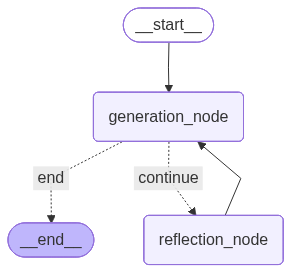

In [ ]:
app

In [ ]:
human_input_message = HumanMessage(content="do u think elon musk is going to take over mars")

print("\n--- Human Input ---")
print(human_input_message.content)

for s in app.stream(human_input_message):
    if "generation_node" in s:
        print("\n--- AI Generates ---")
        print(s["generation_node"].content)
    elif "reflection_node" in s:
        print("\n--- AI Reflects ---")
        print(s["reflection_node"].content)


--- Human Input ---
do u think elon musk is going to take over mars

--- AI Generates ---
While Elon Musk's ambition to colonize Mars is legendary, predicting a "takeover" is a bit strong! 😉 It's more about establishing a sustainable human presence. 🚀

Here's a thread on what that might look like:

1/ SpaceX's Starship is the key player here. This massive rocket is designed for interplanetary travel, aiming to ferry both people and cargo to the Red Planet. Think of it as the ultimate Mars shuttle! 🌌 #Starship #SpaceX

2/ The goal isn't just a quick visit, but building a self-sustaining city. This means developing technologies for generating oxygen, growing food, and finding water on Mars. 💧🌱 #MarsColonization #FutureOfHumanity

3/ Challenges abound, of course! The journey is long, radiation is a major concern, and the Martian environment is incredibly harsh. 😬 But innovation is happening at warp speed! ⚡️ #SpaceExploration #Tech

4/ Musk envisions Mars as a backup for humanity, a way 

In [ ]:
# structured output :

class joker(TypedDict):
  '''tells the joke'''
  joke : Annotated[str,..., "the joke to tell the user"]
  punch : Annotated[str,...,"the punch line of the joke"]
  rate : Annotated[int,...,"rating for the joke b/w 1 to 10"]

structured_output = llm.with_structured_output(joker)

structured_output.invoke("tell a joke about tall buildings")

{'joke': 'Why are tall buildings so smart?',
 'rate': 10,
 'punch': 'Because they have many stories!'}

## Add reflexion agent here--------

## ReACT agent :  [using create_agent and pre-built template from langgraph]  - ### FIX THE BELOW - TRY USING messages: Annotated[list, add_messages] AND USE A CUSTOM PROMPT INSTEAD OF PULL FROM HUB -- LOOK AT THE PROBLEM WITH GEMINI API - HUMANMESSAGE

In [8]:
from google.colab import userdata
tavil_key = userdata.get('tavily_key')

In [ ]:
# pip install langchain-community

In [9]:
from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_classic import hub
import datetime


In [ ]:
# func to get the current sys time

@tool
def get_current_datetime():

  """Returns the current system date and time as a string."""
  return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


# tavily search tool

search_tool = TavilySearchResults(tavily_api_key=tavil_key,search_depth="basic")

react_prompt = hub.pull("hwchase17/react")


In [ ]:
react_prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}')

In [ ]:
react_prompt.template

'Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}'

In [ ]:
tools = [get_current_datetime,search_tool]

In [ ]:
react_agent_runnable = create_agent(tools=tools, model=llm, system_prompt=react_prompt.template)

# react_agent_runnable - returns agentaction or agentfinish

In [ ]:
# state

import operator
from typing import Annotated, TypedDict, Union

from langchain_core.agents import AgentAction, AgentFinish


class Agentstate(TypedDict) :

  messages: Annotated[Sequence[BaseMessage], add_messages]
  agent_outcome : Union[AgentAction,AgentFinish,None]
  intermediate_steps : Annotated[list[(AgentAction,str)],operator.add]


In [ ]:
# nodes

# sys prompt process node

def reason_node(state:Agentstate) -> Agentstate :

  # user_message = HumanMessage(content=state['input'])

  outcome = react_agent_runnable.invoke(
        {
            "messages": state['messages'],
            "intermediate_steps": state['intermediate_steps'],


        }
    )


  state['agent_outcome'] = outcome
  return state


In [ ]:
from langgraph.prebuilt import ToolNode

tool_executor_node = ToolNode(tools=tools)

In [ ]:

def should_cont(state:Agentstate) -> str :
  if isinstance(state['agent_outcome'],AgentFinish):
    return "endit"
  else :
    return "continue"

In [ ]:
gf = StateGraph(Agentstate)

gf.add_node("reason_node",reason_node)
gf.set_entry_point("reason_node")

gf.add_node("tool_noder",tool_executor_node)

gf.add_conditional_edges("reason_node",should_cont,
                         {"continue":"tool_noder","endit":END})

gf.add_edge("tool_noder","reason_node")

app = gf.compile()


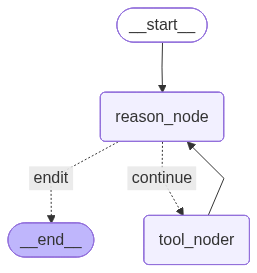

In [ ]:
app

In [ ]:
# taking input from user :

inp = input("enter ur message : ")


while True :

  if inp.lower() == "exit" :

    print("end of our journey bye :> ")

    break

  intial = Agentstate(input=inp, agent_outcome=None, intermediate_steps=[])

  ans = app.invoke(intial)

  if isinstance(ans['agent_outcome'], AgentFinish):
          print(f"\nFinal Answer: {ans['agent_outcome'].return_values['output']}")

  inp = input("enter ur message : ")



enter ur message : how many days has it been since donald trump took the office ?


ValueError: No content messages found. The Gemini API requires at least one non-system message (HumanMessage, AIMessage, etc.) in addition to any SystemMessage. Please include additional messages in your input.

## Basic chatbot :

In [ ]:
# state
class basic_chat(TypedDict):

  messages : Annotated[list,add_messages]

In [ ]:
def process(state : basic_chat) -> basic_chat :
  state['messages'] = llm.invoke(state['messages'])
  return state

In [ ]:
# nodes
gf = StateGraph(basic_chat)

gf.add_node("process_node",process)

gf.set_entry_point("process_node")

gf.add_edge("process_node",END)

app = gf.compile()

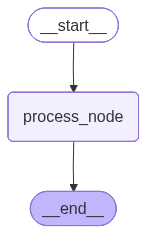

In [ ]:
app

In [ ]:
# taking input from user :

inp = input("enter ur message : ")


while True :

  if inp.lower() == "exit" :

    print("end of our journey bye :> ")

    break

  intial = basic_chat(messages=[HumanMessage(content=inp)])

  ans = app.invoke(intial)

  #  result = app.invoke({
  #           "messages": [HumanMessage(content=user_input)]
  #       })

  print(ans['messages'][1].content)


  inp = input("enter ur message : ")



enter ur message : how many days has it been since donald trump took office second term , today's date is 2nd december 2025
Donald Trump has not taken office for a second term. He served one term as President of the United States from January 20, 2017, to January 20, 2021.
enter ur message : think again
Okay, I've thought again.

To help me think again effectively, I need a little more information. Please tell me:

*   **What was the previous topic or question?** What specifically do you want me to reconsider or re-examine?
*   **What aspect of it do you want me to focus on?** Are you looking for a different perspective, more detail, a correction, or something else?
*   **What was your initial thought or concern?** Knowing what prompted you to ask me to "think again" will guide my re-evaluation.

The more context you provide, the better I can adjust my thinking and give you a more relevant and helpful response.

So, please, tell me again what you'd like me to think about!
enter ur mess

In [ ]:
print(ans['messages'][1].content)

Okay, I've thought again.

To help me think again effectively, I need a little more information. Please tell me:

*   **What was the previous topic or question?** What specifically do you want me to reconsider or re-examine?
*   **What aspect of it do you want me to focus on?** Are you looking for a different perspective, more detail, a correction, or something else?
*   **What was your initial thought or concern?** Knowing what prompted you to ask me to "think again" will guide my re-evaluation.

The more context you provide, the better I can adjust my thinking and give you a more relevant and helpful response.

So, please, tell me again what you'd like me to think about!


## tool router :

In [10]:
# state
class tool_route(TypedDict):

  messages : Annotated[list,add_messages]

In [11]:
search_tool = TavilySearchResults(tavily_api_key=tavil_key,search_depth="basic",max_results=2)

tools = [search_tool]


/tmp/ipython-input-3116000649.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(tavily_api_key=tavil_key,search_depth="basic",max_results=2)


In [12]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite",api_key=api,max_tokens=250)

llm_tools = llm.bind(tools=tools)


In [32]:
def process(state : tool_route) -> tool_route :

  state['messages'] = llm_tools.invoke(state['messages'])
  return state


captured_msg = None

def tool_use(state : tool_route) :

  global captured_msg

  last_msg = state['messages'][-1]

  captured_msg = last_msg

  if (hasattr(last_msg,"tool_calls") and len(last_msg.tool_calls) >0 ) :

    return "use_the_tool"

  else :
    return END



In [24]:
tooler = ToolNode(tools=tools)

gf = StateGraph(tool_route)

gf.add_node("process_node",process)
gf.add_node("tool_node",tooler)
gf.set_entry_point("process_node")

gf.add_conditional_edges("process_node",tool_use,
                         {"use_the_tool":"tool_node", END: END})

gf.add_edge("tool_node","process_node")

app = gf.compile()


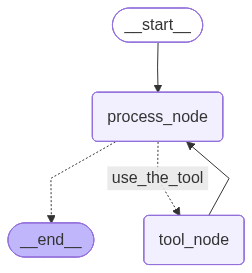

In [25]:
app

In [26]:
ans = app.invoke(tool_route(messages=[HumanMessage(content="what is the current price of bitcoin")]))

print(ans['messages'][-1].content)

The current price of Bitcoin is approximately $90,623.81 USD, with a slight increase of about 1% in the past 24 hours.


In [17]:
ans

{'messages': [HumanMessage(content='what is the current price of bitcoin', additional_kwargs={}, response_metadata={}, id='cfd0e6b9-1075-4a91-a78a-e7a8026b4c04'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current price of bitcoin"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--a77ba262-4eee-456b-935a-110caec69a8c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current price of bitcoin'}, 'id': '3799eb1c-a698-455b-8352-11bb523b1916', 'type': 'tool_call'}], usage_metadata={'input_tokens': 81, 'output_tokens': 24, 'total_tokens': 105, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"title": "BTC USD — Bitcoin Price and Chart", "url": "https://www.tradingview.com/symbols/BTCUSD/", "content": "T

In [42]:
result = app.invoke(tool_route(messages=[HumanMessage(content="what is the current price of bitcoin")]))


last_msg_debug = result['messages'][-1]

public_attributes = [attr for attr in dir(last_msg_debug) if not attr.startswith('__')]

print("--- Public Attributes of Last Message ---")
print(public_attributes)

--- Public Attributes of Last Message ---
['_abc_impl', '_backwards_compat_tool_calls', '_calculate_keys', '_copy_and_set_values', '_get_value', '_iter', '_setattr_handler', 'additional_kwargs', 'construct', 'content', 'content_blocks', 'copy', 'dict', 'from_orm', 'get_lc_namespace', 'id', 'invalid_tool_calls', 'is_lc_serializable', 'json', 'lc_attributes', 'lc_id', 'lc_secrets', 'model_computed_fields', 'model_config', 'model_construct', 'model_copy', 'model_dump', 'model_dump_json', 'model_extra', 'model_fields', 'model_fields_set', 'model_json_schema', 'model_parametrized_name', 'model_post_init', 'model_rebuild', 'model_validate', 'model_validate_json', 'model_validate_strings', 'name', 'parse_file', 'parse_obj', 'parse_raw', 'pretty_print', 'pretty_repr', 'response_metadata', 'schema', 'schema_json', 'text', 'to_json', 'to_json_not_implemented', 'tool_calls', 'type', 'update_forward_refs', 'usage_metadata', 'validate']


In [46]:
for each in public_attributes:
  print(each)

_abc_impl
_backwards_compat_tool_calls
_calculate_keys
_copy_and_set_values
_get_value
_iter
_setattr_handler
additional_kwargs
construct
content
content_blocks
copy
dict
from_orm
get_lc_namespace
id
invalid_tool_calls
is_lc_serializable
json
lc_attributes
lc_id
lc_secrets
model_computed_fields
model_config
model_construct
model_copy
model_dump
model_dump_json
model_extra
model_fields
model_fields_set
model_json_schema
model_parametrized_name
model_post_init
model_rebuild
model_validate
model_validate_json
model_validate_strings
name
parse_file
parse_obj
parse_raw
pretty_print
pretty_repr
response_metadata
schema
schema_json
text
to_json
to_json_not_implemented
tool_calls
type
update_forward_refs
usage_metadata
validate


## In- memory checkpointer :

#### Building simple nodes to check the memory pointer : [in - memory is specific to this instance only we can't import prev chats or save externally ]

In [47]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv


from langgraph.checkpoint.memory import MemorySaver

In [48]:
mem = MemorySaver()

In [79]:
# state :

class Agentstate(TypedDict):
  messages : Annotated[List,add_messages]
# nodes

def mem_noder(state : Agentstate) :

  state["messages"]  = llm.invoke(state["messages"])

  return state

gf = StateGraph(Agentstate)

gf.add_node("mem_noder",mem_noder)

gf.set_entry_point("mem_noder")

gf.add_edge("mem_noder",END)

app = gf.compile(checkpointer = mem)  # addign the checkpointer

config = {"configurable": {"thread_id" : 65}}

In [80]:
while True :
  user_inp = input("enter ur query")

  if user_inp.lower() == "exit":
    break
  else :
    res = app.invoke(Agentstate(messages=[HumanMessage(content=user_inp)]),config=config)

    print("AI answer : " + res["messages"][-1].content)

enter ur queryhi iam vijay , iam studiying 10th standard
AI answer : Hi Vijay! It's nice to meet you. Studying 10th standard is a big year, full of important learning.

How are you doing with your studies? Is there anything specific you'd like to talk about or ask? I'm here to help if you have any questions about school, learning, or anything else.
enter ur querycan u tell me inportance of trignometery in my future in 2 sentences ?
AI answer : Trigonometry is crucial for fields like engineering and physics, helping you understand and build structures, analyze motion, and solve complex problems. It also forms the basis for many advanced mathematical concepts and technologies you'll encounter in higher education and various careers.
enter ur querycan u tell me what my name is ?
AI answer : Your name is **Vijay**.
enter ur querywhich standard iam studying ?
AI answer : You are studying **10th standard**.
enter ur queryexit


#### return snapshot of latest checkpoint

In [82]:
print(app.get_state(config = config))

StateSnapshot(values={'messages': [HumanMessage(content='hi my name is vijay , iam studing highscjhool', additional_kwargs={}, response_metadata={}, id='8599832c-b92b-4581-a12e-adec7454fb0f'), HumanMessage(content='hi my name is vijay , iam studiying 10 th standard', additional_kwargs={}, response_metadata={}, id='ef8e35fc-0acc-4ceb-8586-6e8ab9bc1695'), HumanMessage(content='whats up', additional_kwargs={}, response_metadata={}, id='d8087de1-ff77-4f79-a4d8-a29fdc8a774a'), HumanMessage(content='hi iam vijay , iam studiying 10th standard', additional_kwargs={}, response_metadata={}, id='9afc333a-0e38-46e5-a98f-7fe26a138272'), AIMessage(content="Hi Vijay! It's nice to meet you. Studying 10th standard is a big year, full of important learning.\n\nHow are you doing with your studies? Is there anything specific you'd like to talk about or ask? I'm here to help if you have any questions about school, learning, or anything else.", additional_kwargs={}, response_metadata={'prompt_feedback': {'b

In [83]:
# Access the 'values' key specifically
current_state_values = app.get_state(config=config).values

print("--- Current State Values ---")
print(current_state_values)

--- Current State Values ---
{'messages': [HumanMessage(content='hi my name is vijay , iam studing highscjhool', additional_kwargs={}, response_metadata={}, id='8599832c-b92b-4581-a12e-adec7454fb0f'), HumanMessage(content='hi my name is vijay , iam studiying 10 th standard', additional_kwargs={}, response_metadata={}, id='ef8e35fc-0acc-4ceb-8586-6e8ab9bc1695'), HumanMessage(content='whats up', additional_kwargs={}, response_metadata={}, id='d8087de1-ff77-4f79-a4d8-a29fdc8a774a'), HumanMessage(content='hi iam vijay , iam studiying 10th standard', additional_kwargs={}, response_metadata={}, id='9afc333a-0e38-46e5-a98f-7fe26a138272'), AIMessage(content="Hi Vijay! It's nice to meet you. Studying 10th standard is a big year, full of important learning.\n\nHow are you doing with your studies? Is there anything specific you'd like to talk about or ask? I'm here to help if you have any questions about school, learning, or anything else.", additional_kwargs={}, response_metadata={'prompt_feedba

## SqliteSaver -- we can us the chat history and continue later :

#### [Production level] -- even if the server is shut down we can use it ; this will create a .sqlite file .  if u run the same py file again it pulls the state information from the .sqlite file , so that memory is persistance.

In [ ]:
# pip install langgraph-checkpoint-sqlite

In [ ]:
# from langgraph.checkpoint.sqlite import SqliteSaver
# import sqlite3
# sqlite_conn = sqlite3.connect("checkpoint.sqlite", check_same_thread=False)
# memory = SqliteSaver(sqlite_conn)

# app = graph.compile(checkpointer=memory)

## Human in the loop [USING INPUT] :

In [87]:
# STATE

class Agentstate(TypedDict):
  messages : Annotated[List,add_messages]

In [88]:
# nodes

def process(state : Agentstate) -> Agentstate :

  state['messages'] = llm.invoke(state['messages'])

  return state

# conditional node

def human_input(state : Agentstate) -> Agentstate :

  latest_msg = state['messages'][-1].content

  print("\n current latest message : ")

  print(latest_msg)

  print("\n")

  des = input("enter ur message : Do you like the message yes or no :  ")

  if des.lower() == "yes" :
    return "post_it"

  else :

    return "user_feedback"


# post_it

def post_it(state : Agentstate) -> Agentstate :

  final_post = state['messages'][-1].content

  print("\n final post : ")

  print(final_post)

  print("This has been approved by the user")

# user_feedback

def user_feedback(state : Agentstate) -> Agentstate :

  feedback = input("enter ur feedback  and let me know how can i improve it  : ")

  state["messages"].append(HumanMessage(content=feedback))

  return state



In [91]:
gf = StateGraph(Agentstate)

gf.add_node("process_node",process)

gf.set_entry_point("process_node")


gf.add_node("post_it_node",post_it)

gf.add_node("user_feedback_node",user_feedback)

gf.add_conditional_edges("process_node",human_input,
                         {"post_it":"post_it_node","user_feedback":"user_feedback_node"})

gf.add_edge("post_it_node",END)

gf.add_edge("user_feedback_node","process_node")

app = gf.compile()

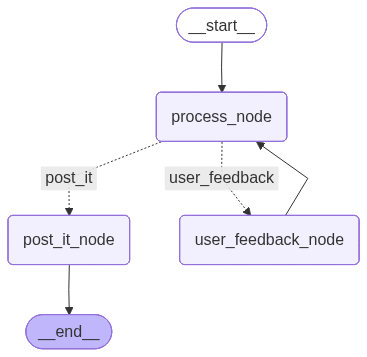

In [92]:
app

In [94]:
res = app.invoke(Agentstate(messages=[HumanMessage(content="generate a linkedin post about the future of bitcoin")]))


 current latest message : 
Here are a few options for a LinkedIn post about the future of Bitcoin, ranging in tone and focus. Choose the one that best suits your audience and personal brand!

---

**Option 1: Balanced & Forward-Looking**

**Headline:** Navigating the Evolving Landscape: What's Next for Bitcoin? 🚀

**Body:**
The conversation around Bitcoin is more dynamic than ever. Beyond its current price fluctuations, the underlying technology and its potential applications continue to spark debate and innovation.

As we look ahead, key trends to watch include:

*   **Institutional Adoption:** The growing involvement of traditional financial institutions is a significant signal, potentially leading to greater stability and broader accessibility.
*   **Technological Advancements:** Layer 2 solutions and ongoing protocol upgrades are addressing scalability and transaction efficiency, paving the way for wider use cases.
*   **Regulatory Clarity:** As governments worldwide grapple with 